In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker as ticker

from datetime import datetime
from IPython.display import display

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# df = pd.read_csv('./csv/testing.csv')
df = pd.read_csv('csv/0701-0922.csv')
df.head()

,adsetID_date,date_start,date_stop,hour_clicks,hour_spend,hour_impression,hour_ctr,hour
0,23852157411620227_00:00:00 - 00:59:59,2022-09-03,2022-09-03,0,5,23,0.0,00:00:00 - 00:59:59
1,23852157411620227_01:00:00 - 01:59:59,2022-09-03,2022-09-03,0,6,14,0.0,01:00:00 - 01:59:59
2,23852157411620227_02:00:00 - 02:59:59,2022-09-03,2022-09-03,0,6,16,0.0,02:00:00 - 02:59:59
3,23852157411620227_03:00:00 - 03:59:59,2022-09-03,2022-09-03,0,7,11,0.0,03:00:00 - 03:59:59
4,23852157411620227_04:00:00 - 04:59:59,2022-09-03,2022-09-03,0,2,6,0.0,04:00:00 - 04:59:59


### Create Year | Month | Day | Hour List 

- 1.Create Divide same Adset with different date List
- 2.spend_per_hour List

### Built hour spend & hour Dataframe , Plot the data

#### Function List explanation : 

- 1.create_adsetID_CPM_df : create hour-CPM and adsetID 
- 2.list_date_all : save the date list in unique adset
- 3.turnDF_and_dropIndex : 
- 4.hour_dataframe : create multi-feature per-hour dataframe 
- 5.Plot_data : visualize the data by plot 
- 6.multiple_date_plot

In [55]:
def create_adsetID_CPM_df():
    LIST_Adset = []
    df_ = df["adsetID_date"]
    List_adsetID = df_.values.tolist()
    adsetID = List_adsetID[:]
    for i in range(len(adsetID)): 
        adset = adsetID[i]
        adset_ID = adset[:17]
        LIST_Adset.append(adset_ID)
    df["adsetID"] = LIST_Adset
    df["hour_CPM"] = (df["hour_spend"]/df["hour_impression"])*100
    display(df)

# show unique date's data by same Adset 
def list_date_all():
    group_Adset_ID = df.groupby("adsetID")
    df_ID = group_Adset_ID.get_group(adset_ID)
    list_dateall = df_ID["date_start"].unique()
    return list_dateall

def turnDF_and_dropIndex(feature):
    feature = pd.DataFrame(feature)    
    feature = feature.reset_index(drop=True)
    return feature

# create per-hour dataframe
def hour_dataframe(adset_ID, date):
    group_Adset_ID = df.groupby("adsetID")
    df_ID = group_Adset_ID.get_group(adset_ID)
    df_bydate = df_ID.groupby("date_start")
    DF = df_bydate.get_group(date)
    
    # Feature
    hour = DF.hour
    spend = DF.hour_spend
    impression = DF.hour_impression
    clicks = DF.hour_clicks
    ctr = DF.hour_ctr
    CPM = DF.hour_CPM

    # ============ 1.list_pure_hour ============== #
    list_pure_hour = []
    from datetime import datetime, timedelta
    startDate = datetime(2022,9,21,0,0) 
    endDate = datetime(2022,9,21,23,59)
    currentDate = startDate
    while(currentDate<=endDate):
        str_currentDate = currentDate.strftime("%m/%d/%Y, %H:%M:%S")
        str_currentDate = str_currentDate[12:-3]
        filter_ = str_currentDate[:1]
        if filter_ == "0":
            hour_remove_0 = str_currentDate[1:]
            list_pure_hour.append(hour_remove_0)
        else : 
            list_pure_hour.append(str_currentDate)
        currentDate = currentDate + timedelta(hours=1)
    
    # ============ 2.Feature ============== #
    # === 2.1 hour_spend === #
    list_hour_spend = []
    list_dict_hour_spend = []
    list_hour = list(hour)
    for i in range(len(list_hour)):
        total_time = list_hour[i]
        oclock = total_time[:5]
        filter_ = oclock[:1]
        if filter_ == "0":
            lower_10 = list_hour[i]
            lower_10 = lower_10[1:5]
            list_hour_spend.append(lower_10)
            dict_list_hour_spend = {'hour': lower_10}
            list_dict_hour_spend.append(dict_list_hour_spend)
        else :
            list_hour_spend.append(oclock)
            dict_list_hour_spend = {'hour': oclock}
            list_dict_hour_spend.append(dict_list_hour_spend)
    df_list_hour = pd.DataFrame(list_dict_hour_spend)

    # === 2.2 Turn features to DF === #
    df_spend = turnDF_and_dropIndex(spend)
    df_impression = turnDF_and_dropIndex(impression)
    df_clicks = turnDF_and_dropIndex(clicks)
    df_ctr = turnDF_and_dropIndex(ctr)
    df_CPM = turnDF_and_dropIndex(CPM)
    
    # === 2.3  concat all feature === #   
    concat = pd.concat([df_list_hour,df_spend,df_impression,df_clicks,df_ctr,df_CPM],axis=1)
    
    # ============ 3.find missing hour ============== #
    list_missing_hour = []
    list_with_dict = []
    for i in list_pure_hour:
        if i not in list_hour_spend:
            dict_blank_add = {'hour': i, 'hour_spend': "0", 'hour_impression': "0", 'hour_clicks': "0","hour_ctr":"0","hour_CPM":"0"}
            list_missing_hour.append(dict_blank_add)
    #list_missing_hour = [i for i in list_pure_hour if i not in list_hour_spend]
    df_list_missing_hour = pd.DataFrame(list_missing_hour)
    
    # ============ 4.concat ============== #
    df_all = pd.concat([concat,df_list_missing_hour],axis=0)
    df_all["hour_int"] = df_all["hour"].str[:-3]
    df_all['hour_int']=df_all['hour_int'].astype(int)
    df_all['hour_spend']=df_all['hour_spend'].astype(int)
    df_all['hour_impression']=df_all['hour_impression'].astype(float)
    df_all['hour_clicks']=df_all['hour_clicks'].astype(float)
    df_all['hour_CPM/10']=df_all['hour_CPM'].astype(float)

    df_all = df_all.sort_values(by=['hour_int'])
    return df_all

def plot_data(adset_ID, date):
    
    df_all = hour_dataframe(adset_ID, date)
    # bar
    df_all.plot(x="hour", y=["hour_spend", "hour_impression","hour_clicks","hour_CPM/10"], kind="bar", figsize=(14, 6))
    plt.title(date +" Plot hour with hour_spend | hour_impression | hour_clicks",fontsize=15,fontstyle='italic')
     
    # line
    df_all.plot(x="hour", y=["hour_spend", "hour_impression","hour_clicks","hour_CPM/10"], kind="line", figsize=(14, 6))

    # dot 
    plt.figure(figsize=(14, 6))
    plt.scatter(df_all["hour"], df_all["hour_spend"])
    plt.show()
    
def multiple_date_plot(adset_ID):
    create_adsetID_CPM_df()
    list_dateall = list_date_all()
    for i in range(len(list_dateall)):
        date = list_dateall[i]
        plot_data(adset_ID, date)

,adsetID_date,date_start,date_stop,hour_clicks,hour_spend,hour_impression,hour_ctr,hour,adsetID,hour_CPM
0,23852157411620227_00:00:00 - 00:59:59,2022-09-03,2022-09-03,0,5,23,0.000000,00:00:00 - 00:59:59,23852157411620227,21.739130
1,23852157411620227_01:00:00 - 01:59:59,2022-09-03,2022-09-03,0,6,14,0.000000,01:00:00 - 01:59:59,23852157411620227,42.857143
2,23852157411620227_02:00:00 - 02:59:59,2022-09-03,2022-09-03,0,6,16,0.000000,02:00:00 - 02:59:59,23852157411620227,37.500000
3,23852157411620227_03:00:00 - 03:59:59,2022-09-03,2022-09-03,0,7,11,0.000000,03:00:00 - 03:59:59,23852157411620227,63.636364
4,23852157411620227_04:00:00 - 04:59:59,2022-09-03,2022-09-03,0,2,6,0.000000,04:00:00 - 04:59:59,23852157411620227,33.333333
...,...,...,...,...,...,...,...,...,...,...
595,23851883812620227_07:00:00 - 07:59:59,2022-08-09,2022-08-09,0,22,55,0.000000,07:00:00 - 07:59:59,23851883812620227,40.000000
596,23851883812620227_07:00:00 - 07:59:59,2022-08-10,2022-08-10,0,4,14,0.000000,07:00:00 - 07:59:59,23851883812620227,28.571429
597,23851883812620227_07:00:00 - 07:59:59,2022-08-11,2022-08-11,3,13,41,7.317073,07:00:00 - 07:59:59,23851883812620227,31.707317
598,23851883812620227_08:00:00 - 08:59:59,2022-08-09,2022-08-09,0,10,33,0.000000,08:00:00 - 08:59:59,23851883812620227,30.303030


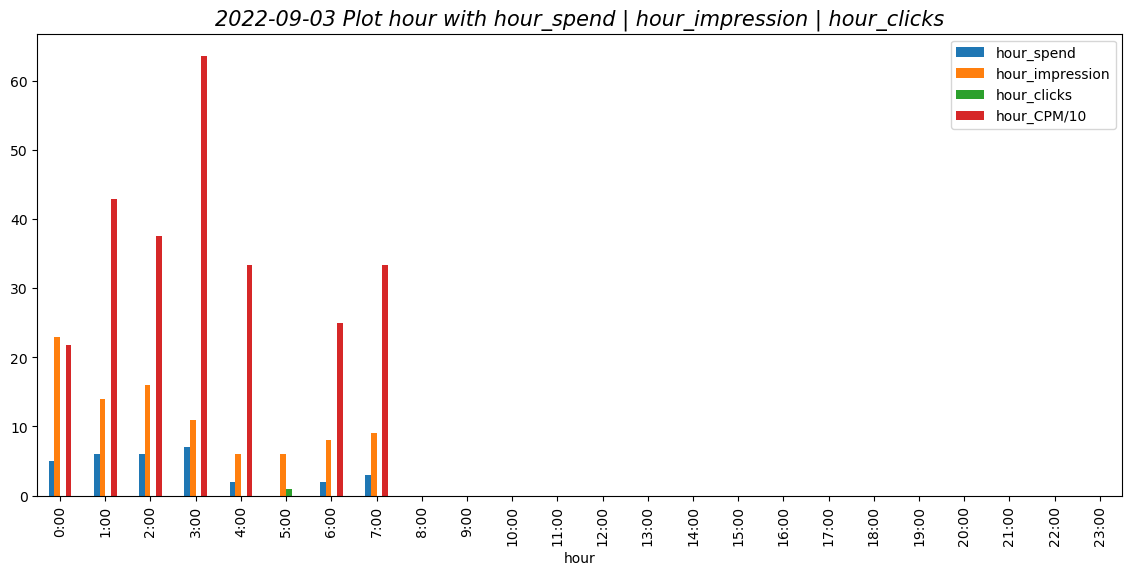

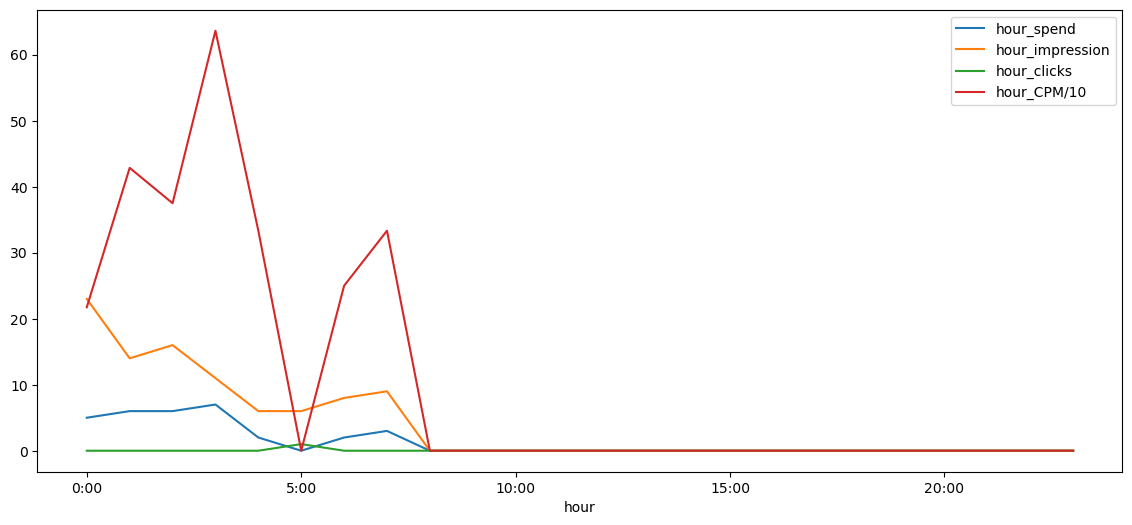

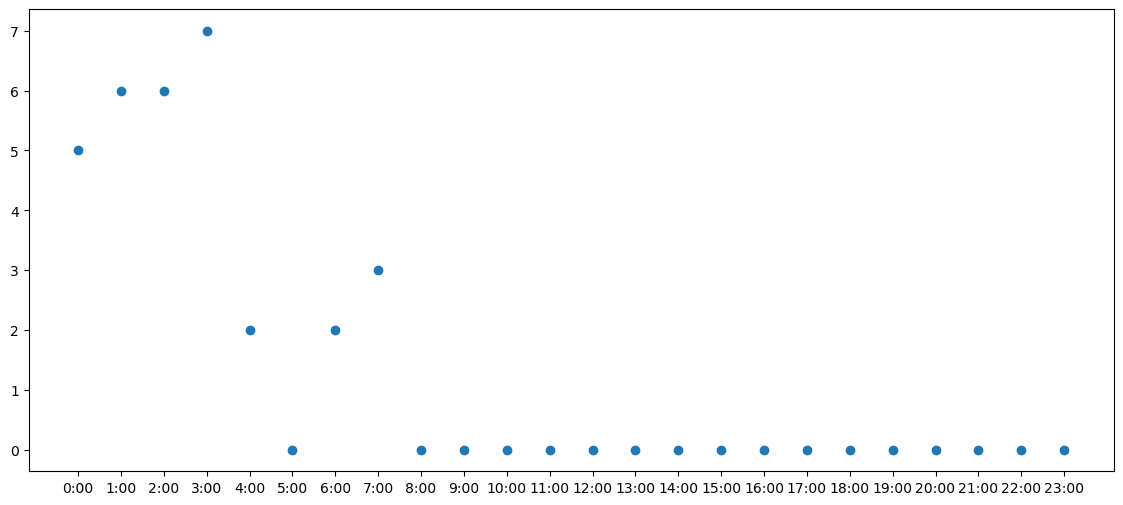

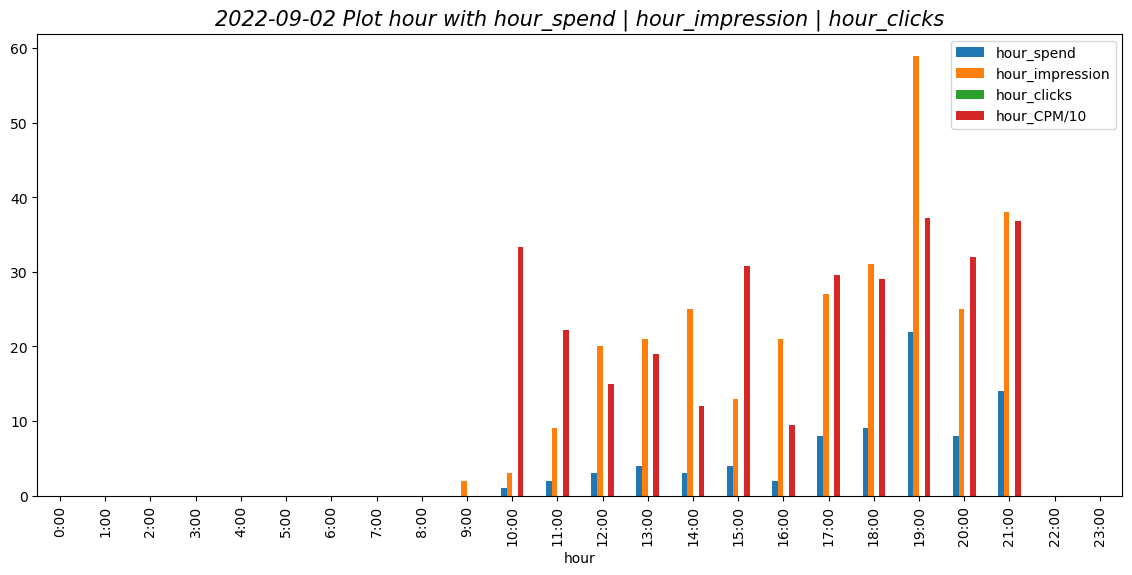

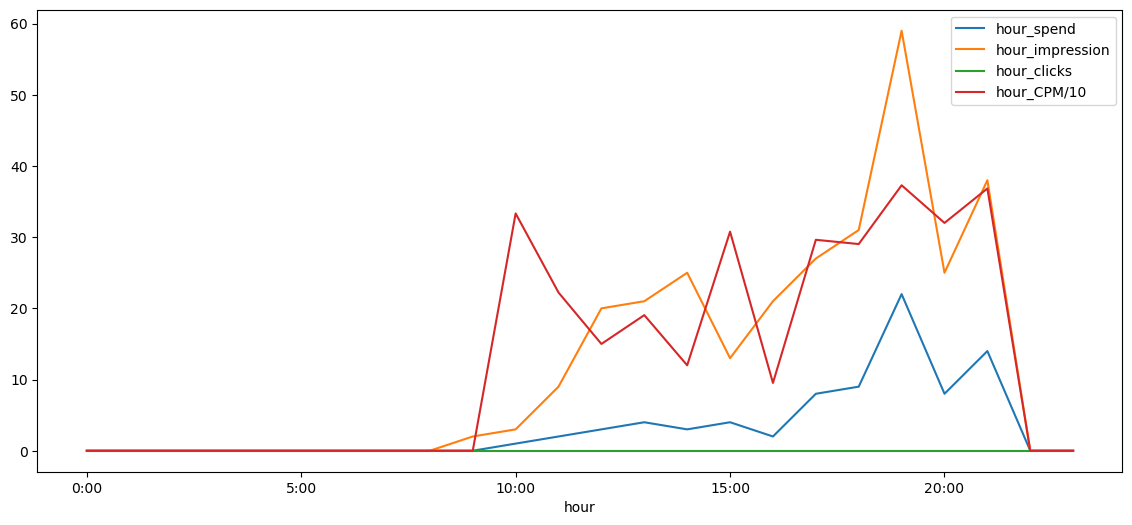

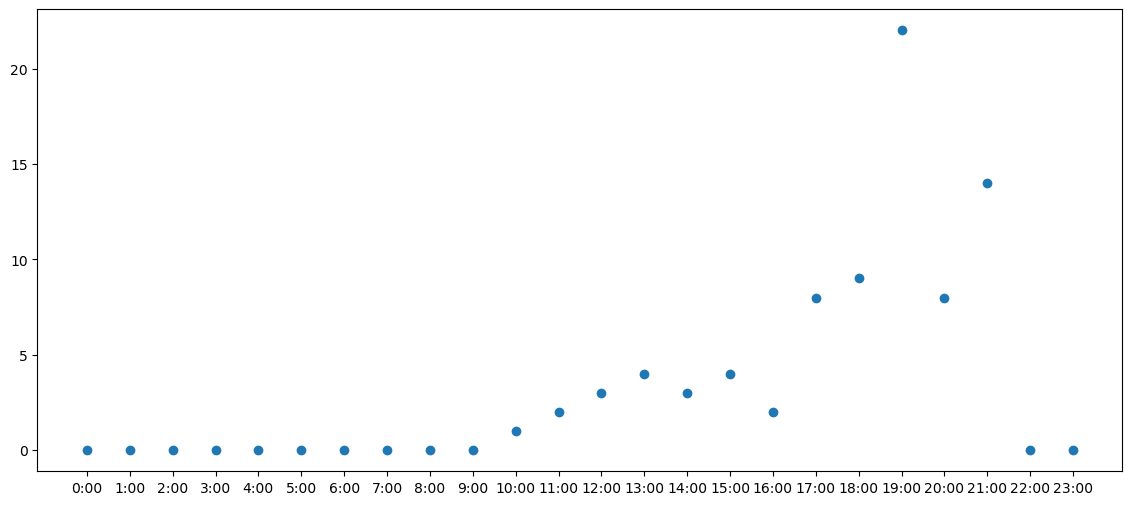

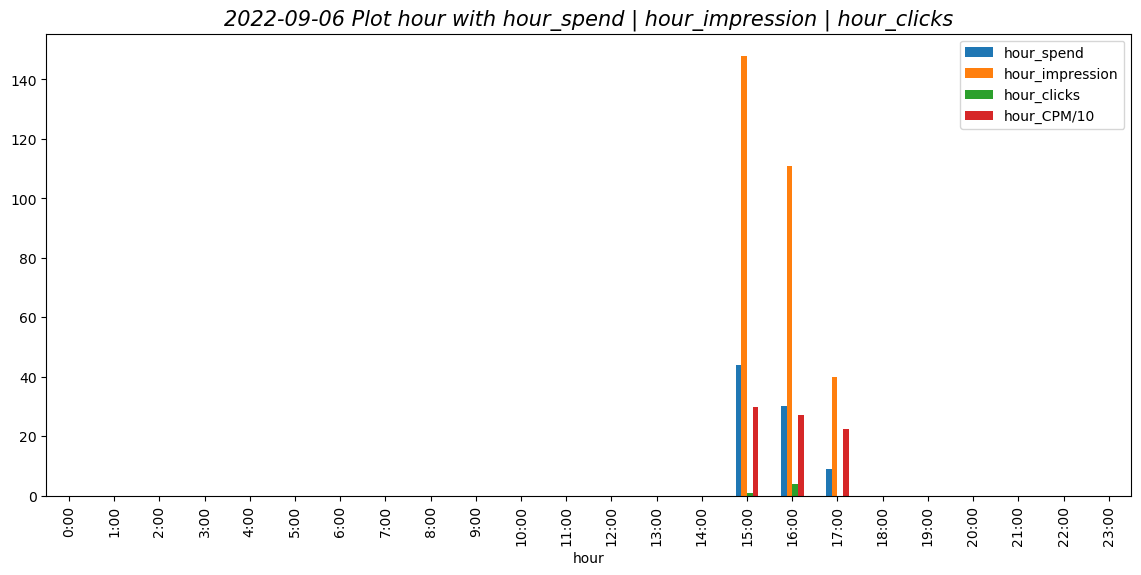

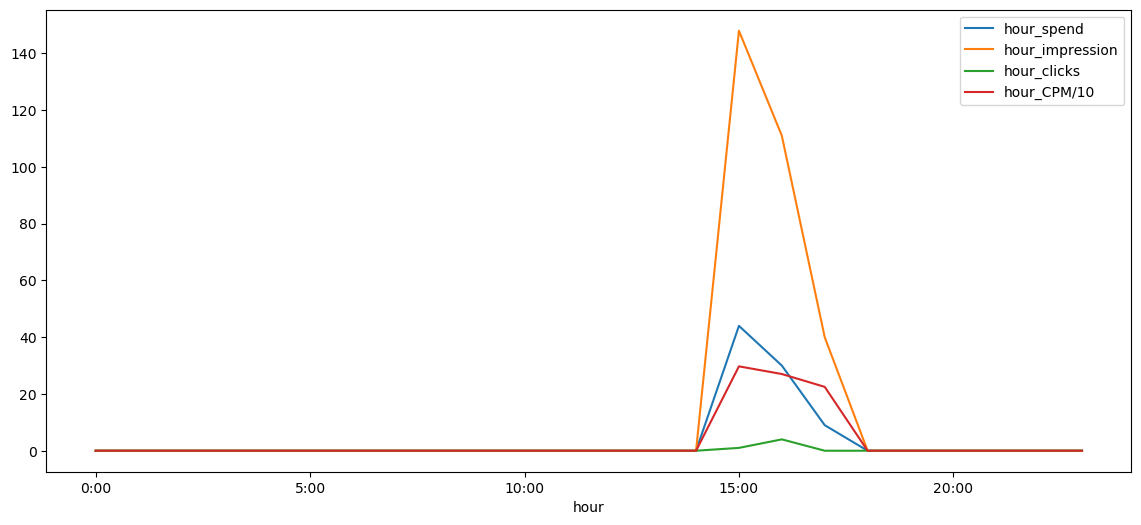

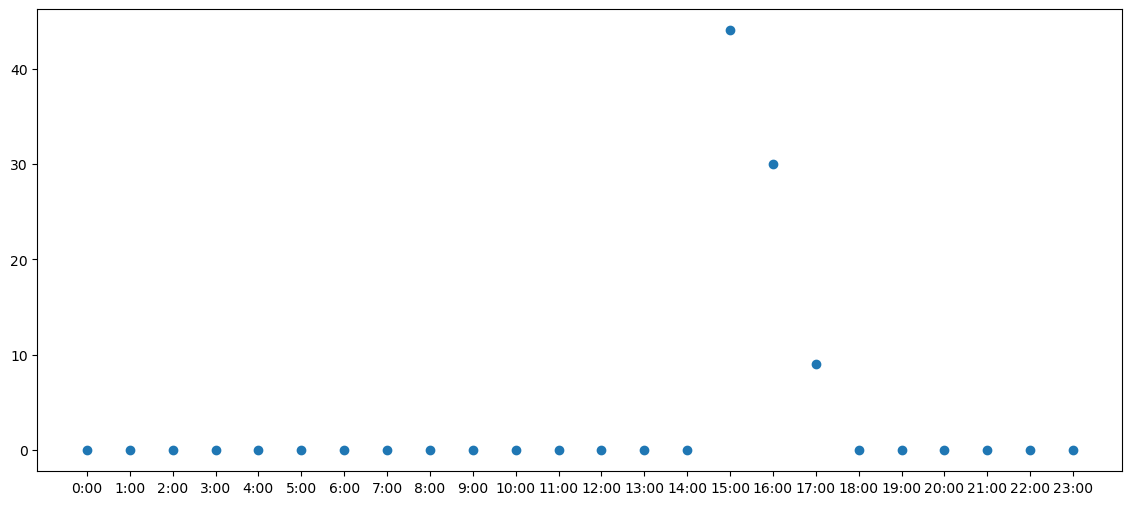

In [58]:
adset_ID = "23852157411620227"
multiple_date_plot(adset_ID)

#### 將取出的日期資訊放入datetime function 得到畫圖input

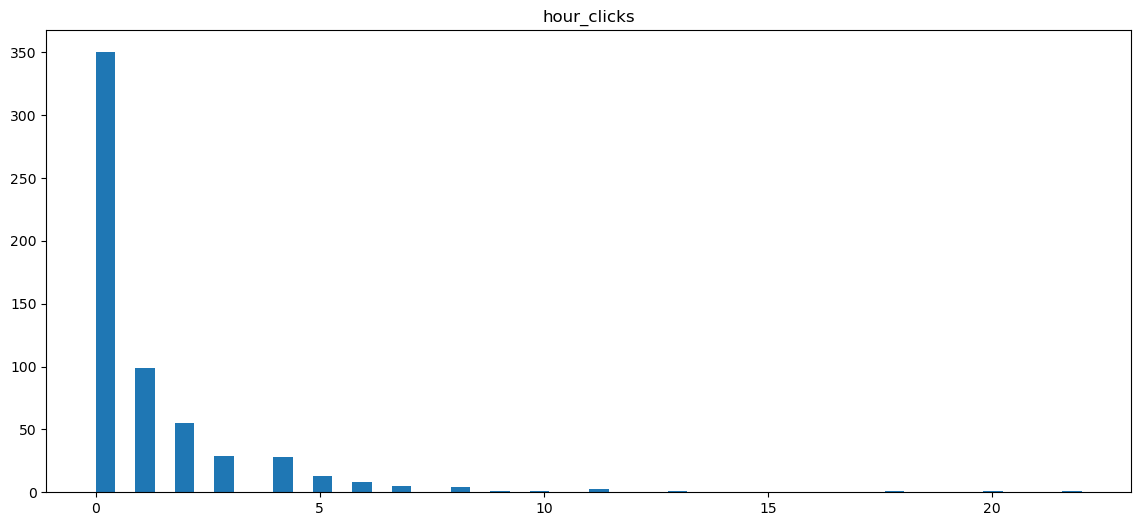

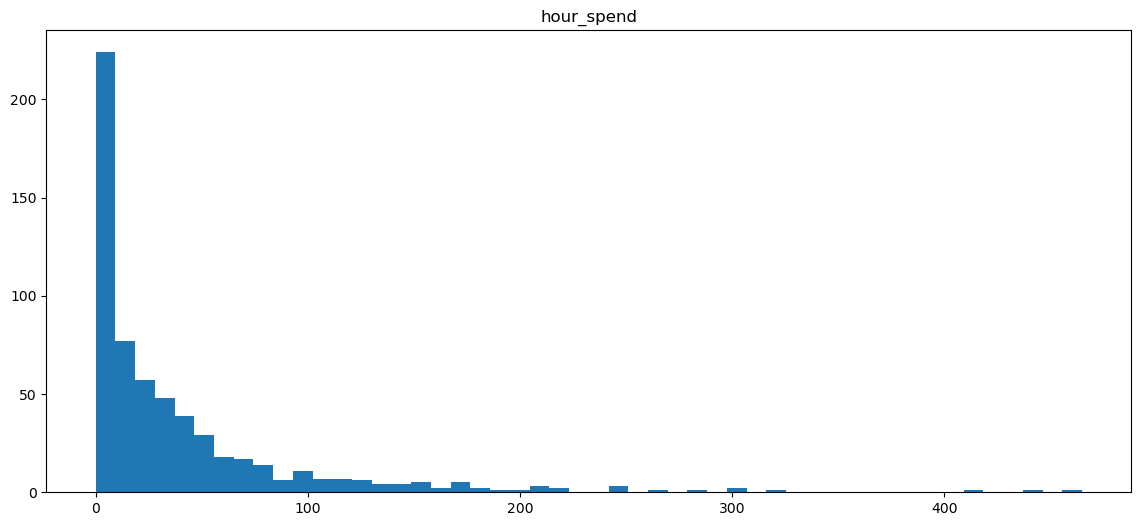

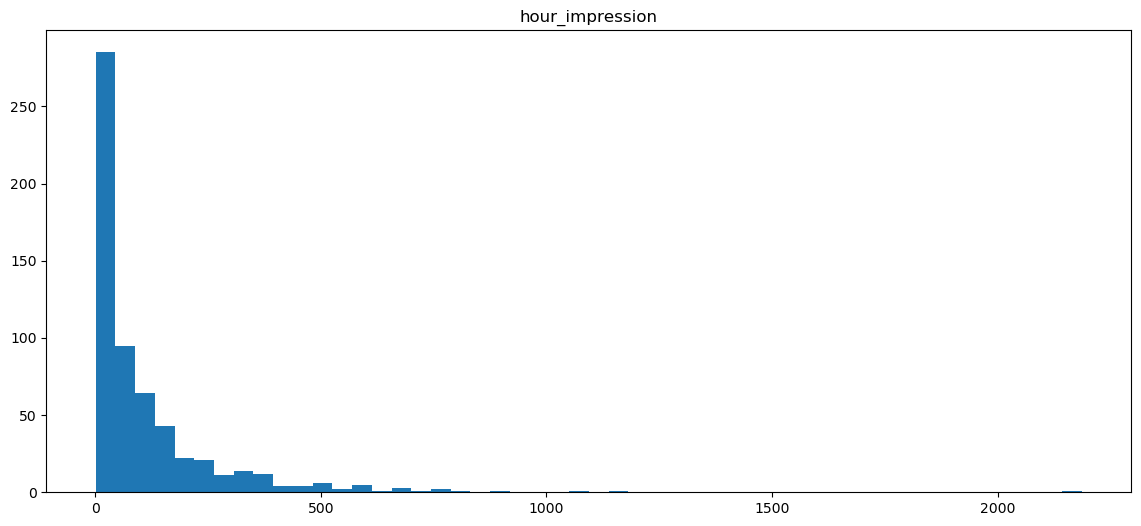

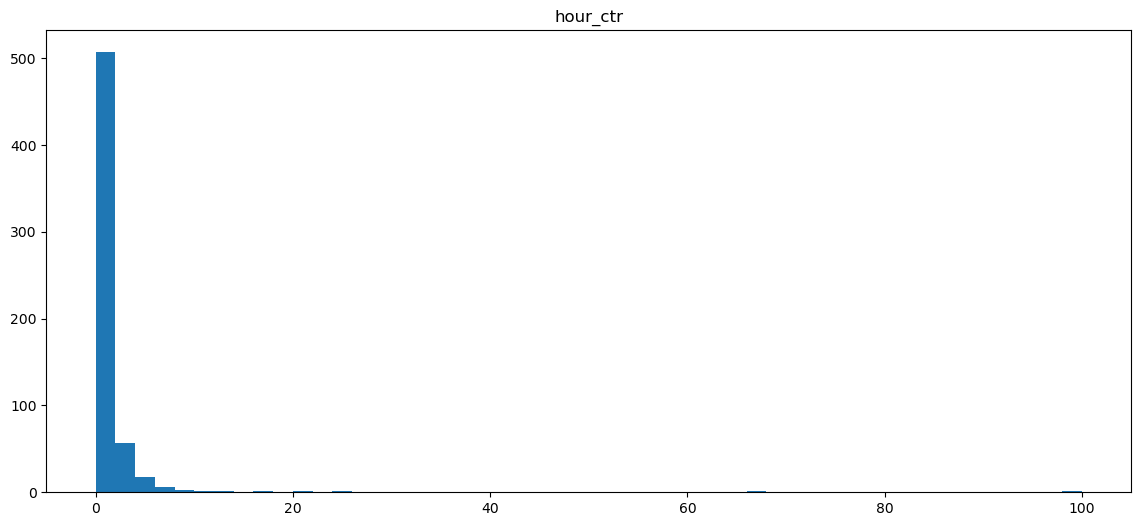

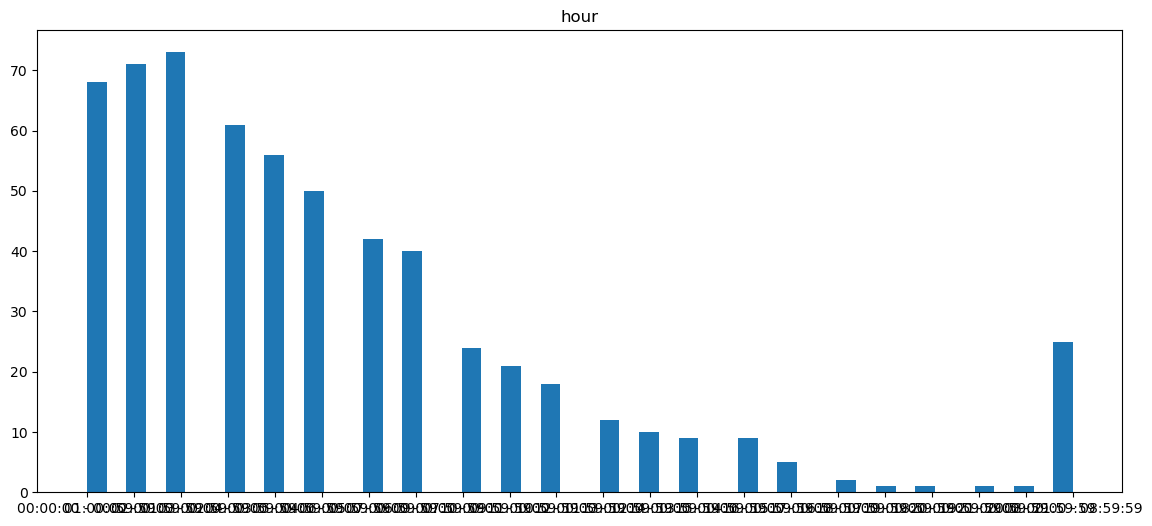

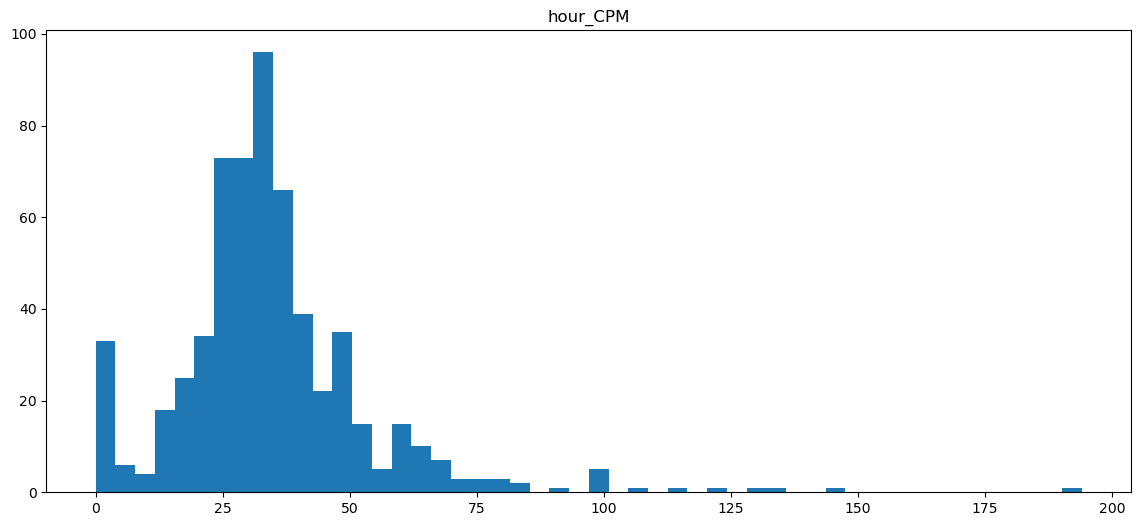

In [59]:
keys = df.keys()
lst_keys=[i for i in keys if "hour" in i]
# print(lst_perday)

for i in lst_keys :
    dat=df[i].dropna()
    #print("dat : \n",dat)
    plt.figure(figsize=(14, 6))
    plt.hist(dat, bins=50)
    plt.title(i)
    plt.show()